# Setup

In [19]:
# import packages
library(lme4)
library(arm)
library(stringr)

In [20]:
# helper function(s)
get_prob_timecourse <- function(iv, DM, score) {
    objs = c('bed', 'bench', 'chair', 'table')
    trained_objs = unique(DM[['label']])
    trained_objs = trained_objs[order(trained_objs)]
    control_objs = c()
    for (obj in objs){
        if (!is.element(obj, trained_objs)) {
            control_objs = append(control_objs, obj) }}

    t1 = trained_objs[1]
    t2 = trained_objs[2]
    c1 = trained_objs[1]
    c2 = control_objs[2]
    
    if (score == 't') {
        return(rowMeans(cbind(
            array(aggregate(DM[DM['label']==toString(t1),]['t1_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['t1_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['t2_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['t2_prob']))))
    } else if (score == 'f') {
        return(rowMeans(cbind(
            array(aggregate(DM[DM['label']==toString(t1),]['t2_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['t2_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['t1_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['t1_prob']))))
    } else {
        return(rowMeans(cbind(
            array(aggregate(DM[DM['label']==toString(t1),]['c1_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['c1_prob']),
            array(aggregate(DM[DM['label']==toString(t1),]['c2_prob'],
                            by=DM[DM['label']==toString(t1),][iv], mean)['c2_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['c1_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['c1_prob']),
            array(aggregate(DM[DM['label']==toString(t2),]['c2_prob'],
                            by=DM[DM['label']==toString(t2),][iv], mean)['c2_prob']))))
    }
}

get_trained_objs <- function(DM) {
    return(unique(DM[['label']]))
}

In [21]:
ALLDM = read.csv("logistic_timeseries_drawing_neural_4way_logged.csv", header = TRUE)
prepost = read.csv('neural_changes_by_surfroi_and_subject.csv', header = TRUE)

# make subject ids in prepost dataframe match format in ALLDM
newcol = integer(nrow(prepost['IDs']))
for (i in 1:nrow(prepost['IDs'])) {
    newcol[i] = as.numeric(substr(prepost['IDs'][i,1], 0, 7))}
prepost['IDs'] = newcol
subs = unique(ALLDM['subj'])
rois = unique(ALLDM['roi'])

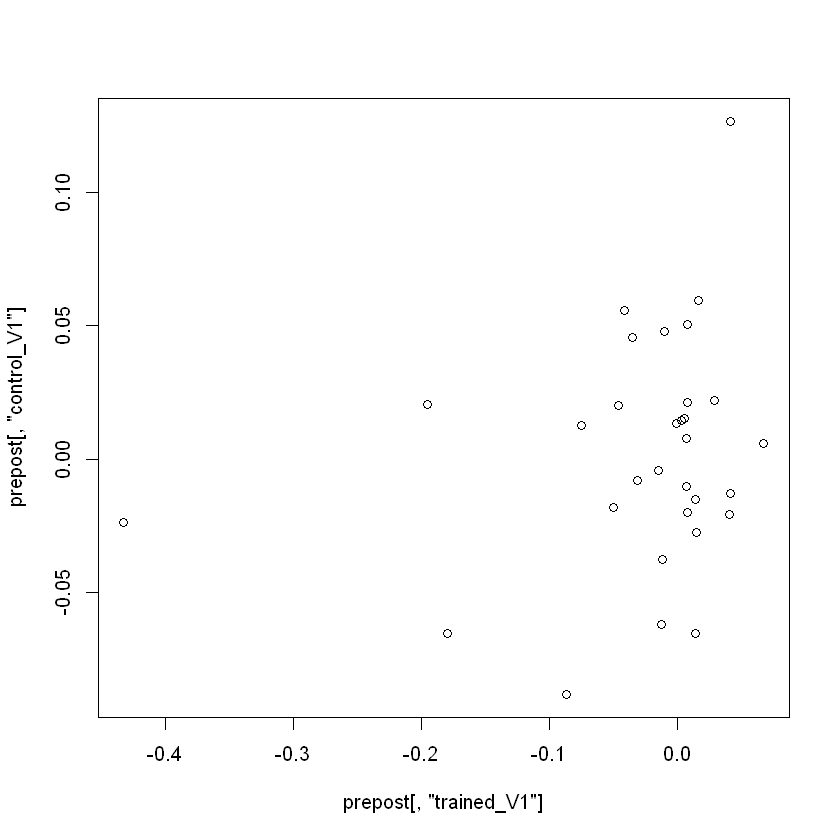

In [22]:
# quick sanity check: does this look like judy's?
prepost = read.csv('neural_changes_by_surfroi_and_subject.csv', header = TRUE)
plot(prepost[,'trained_V1'], prepost[,'control_V1'])

# Make the Data Frame

selectivity,diff,object_assignment
0.21378238,0.019554990,bedbench
-0.24487542,-0.070490518,chairbed
0.02642429,0.013465994,tablebed
0.53382381,-0.140920330,benchchair
0.12025180,-0.017790068,benchtable
0.81801985,-0.028008770,tablechair
0.69826519,-0.022598529,chairbed
1.43940415,-0.041107531,benchchair
0.44644002,0.073080889,benchtable
0.65671144,-0.045690825,tablechair


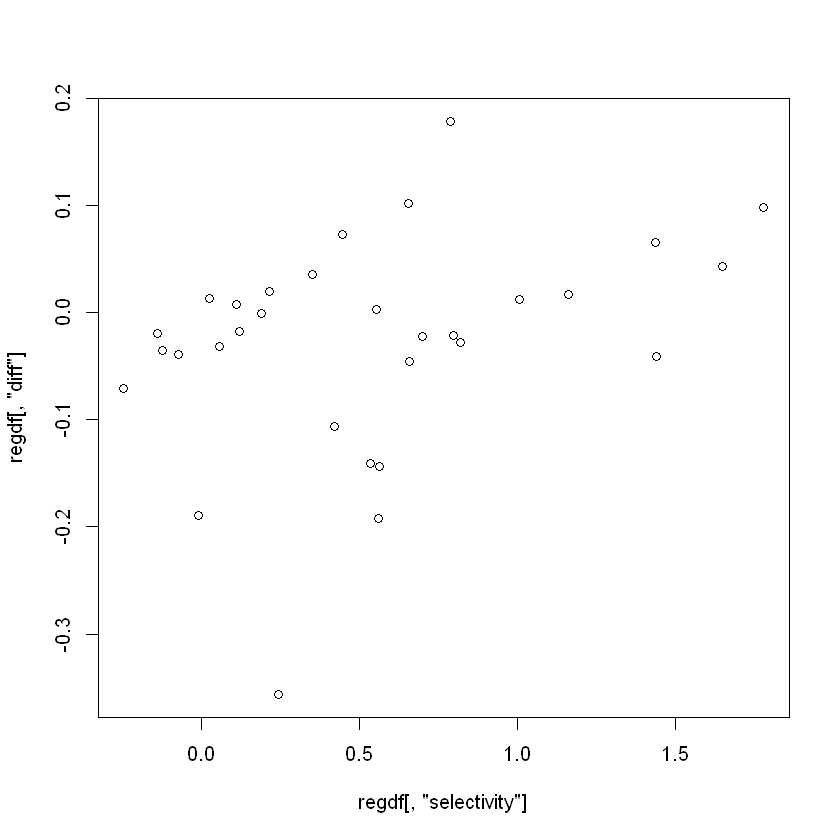

In [23]:
# single roi version
roi = 'V1'
anchored = FALSE

# target selectivity
selectivity = c()
for (sub in subs[,]) {
    inds = (ALLDM['roi']==roi) & (ALLDM['subj']==sub)
    selectivity = append(selectivity,
                         mean(get_prob_timecourse('trial_num', ALLDM[inds,], 't')-
                              get_prob_timecourse('trial_num', ALLDM[inds,], 'f')))}

# training pair
object_assignment = c()
for (sub in subs[,]) {
    inds = (ALLDM['subj']==sub)
    object_assignment = append(object_assignment, str_remove(toString(get_trained_objs(ALLDM[inds,])), ', '))}

# prepost differentiation
if (anchored) {
    diff = prepost[,sprintf('trained_%s', roi)]-prepost[,sprintf('control_%s', roi)]
} else {
    diff = prepost[,sprintf('tradiff_%s', roi)]-prepost[,sprintf('condiff_%s', roi)]
}

regdf = data.frame(selectivity, diff, object_assignment)
regdf['object_assignment'] = as.factor(unlist(regdf['object_assignment']))
regdf
plot(regdf[,'selectivity'], regdf[,'diff'])

In [26]:
cor(regdf[,'selectivity'], regdf[,'diff'])

[1] 0.3442994

### Model Fitting

In [28]:
OLSexamp <- glm(diff ~ selectivity, data = regdf[regdf['object_assignment']=='bedbench',])
summary(OLSexamp)


Call:
glm(formula = diff ~ selectivity, data = regdf[regdf["object_assignment"] == 
    "bedbench", ])

Deviance Residuals: 
       1        12        18        28  
 0.17591   0.04971  -0.18516  -0.04046  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.05338    0.11240  -0.475    0.682
selectivity -0.48164    0.63887  -0.754    0.530

(Dispersion parameter for gaussian family taken to be 0.03466708)

    Null deviance: 0.089038  on 3  degrees of freedom
Residual deviance: 0.069334  on 2  degrees of freedom
AIC: 1.1311

Number of Fisher Scoring iterations: 2


In [29]:
coef(OLSexamp)

(Intercept) selectivity 
  -0.053384   -0.481643

In [30]:
OLSexamp <- glm(diff ~ selectivity, data = regdf[regdf['object_assignment']=='tablechair',])
summary(OLSexamp)


Call:
glm(formula = diff ~ selectivity, data = regdf[regdf["object_assignment"] == 
    "tablechair", ])

Deviance Residuals: 
       6        10        11        17        21        27  
-0.04973  -0.05770   0.01847  -0.02807  -0.04179   0.15883  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.02750    0.09753  -0.282    0.792
selectivity  0.06017    0.08327   0.723    0.510

(Dispersion parameter for gaussian family taken to be 0.008475945)

    Null deviance: 0.038329  on 5  degrees of freedom
Residual deviance: 0.033904  on 4  degrees of freedom
AIC: -8.0287

Number of Fisher Scoring iterations: 2


In [31]:
coef(OLSexamp)

(Intercept) selectivity 
-0.02749783  0.06016689

In [32]:
OLSexamp <- lmer(diff ~ selectivity + (1 + selectivity | object_assignment), data = regdf)
summary(OLSexamp)

Linear mixed model fit by REML ['lmerMod']
Formula: diff ~ selectivity + (1 + selectivity | object_assignment)
   Data: regdf

REML criterion at convergence: -47.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2009 -0.2368  0.2779  0.5158  1.9508 

Random effects:
 Groups            Name        Variance  Std.Dev.  Corr
 object_assignment (Intercept) 0.000e+00 0.000e+00     
                   selectivity 2.121e-24 1.456e-12  NaN
 Residual                      9.417e-03 9.704e-02     
Number of obs: 31, groups:  object_assignment, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.06192    0.02488  -2.488
selectivity  0.06516    0.03299   1.975

Correlation of Fixed Effects:
            (Intr)
selectivity -0.714

In [33]:
coef(OLSexamp)$object_assignment

,(Intercept),selectivity
bedbench,-0.06191565,0.06515661
benchchair,-0.06191565,0.06515661
benchtable,-0.06191565,0.06515661
chairbed,-0.06191565,0.06515661
tablebed,-0.06191565,0.06515661
tablechair,-0.06191565,0.06515661


# Toy Example for Comparison

diff,selectivity,object_assignment
-0.9829552,-1.00,A
-1.3547940,-0.99,A
-0.9815247,-0.98,A
-1.0752960,-0.97,A
-0.4929206,-0.96,A
-0.6462017,-0.95,A


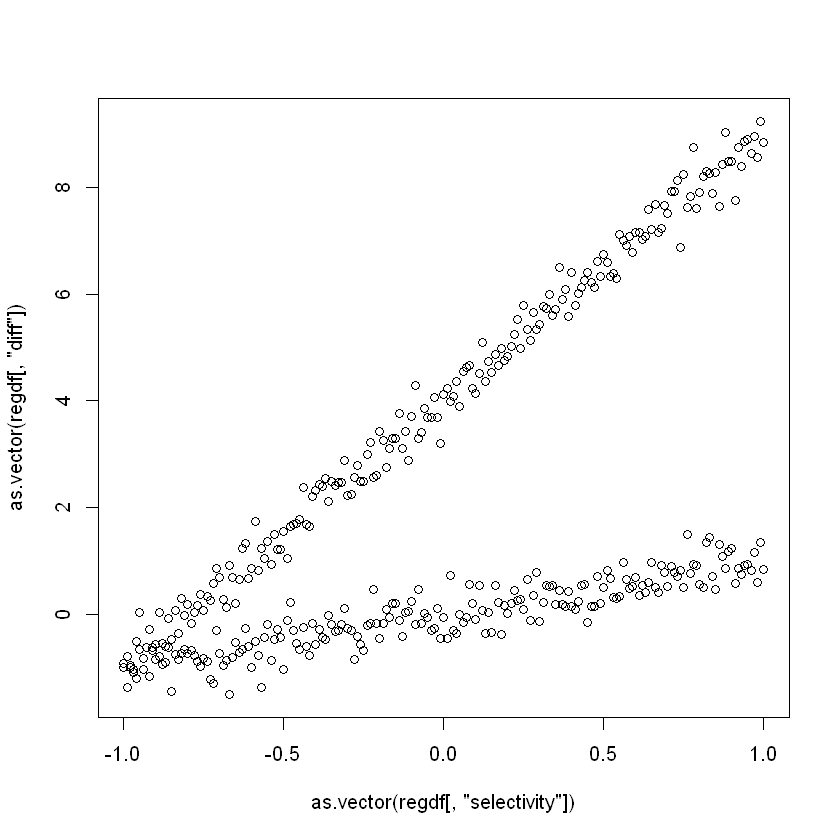

In [34]:
x1 = seq(-1, 1, by=.01)
y1 = seq(-1, 1, by=.01) + rnorm(201, 0, .3)
x2 = seq(-1, 1, by=.01)
y2 = seq(-1, 9, by=.05) + rnorm(201, 0, .3)
regdf = data.frame(c(y1, y2), c(x1, x2), c(rep('A', 201), rep('B', 201)))
colnames(regdf) = c('diff', 'selectivity', 'object_assignment')
regdf['object_assignment'] = as.factor(unlist(regdf['object_assignment']))

head(regdf)
plot(as.vector(regdf[,'selectivity']), as.vector(regdf[,'diff']))

### Model Fitting

In [35]:
OLSexamp <- glm(diff ~ selectivity, data = regdf[regdf['object_assignment']=='A',])
summary(OLSexamp)


Call:
glm(formula = diff ~ selectivity, data = regdf[regdf["object_assignment"] == 
    "A", ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.80929  -0.18234  -0.00138   0.17242   0.74374  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.005243   0.020074  -0.261    0.794    
selectivity  1.015573   0.034597  29.354   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.08099903)

    Null deviance: 85.913  on 200  degrees of freedom
Residual deviance: 16.119  on 199  degrees of freedom
AIC: 69.226

Number of Fisher Scoring iterations: 2


In [36]:
coef(OLSexamp)

(Intercept)  selectivity 
-0.005243312  1.015573119

In [37]:
OLSexamp <- glm(diff ~ selectivity, data = regdf[regdf['object_assignment']=='B',])
summary(OLSexamp)


Call:
glm(formula = diff ~ selectivity, data = regdf[regdf["object_assignment"] == 
    "B", ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.84549  -0.20652   0.00767   0.18247   0.82453  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.02312    0.02053   195.9   <2e-16 ***
selectivity  4.98812    0.03539   140.9   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.0847553)

    Null deviance: 1700.583  on 200  degrees of freedom
Residual deviance:   16.866  on 199  degrees of freedom
AIC: 78.338

Number of Fisher Scoring iterations: 2


In [38]:
coef(OLSexamp)

(Intercept) selectivity 
   4.023121    4.988115

In [39]:
OLSexamp <- lmer(diff ~ selectivity + (1 + selectivity | object_assignment), data = regdf)
summary(OLSexamp)

Linear mixed model fit by REML ['lmerMod']
Formula: diff ~ selectivity + (1 + selectivity | object_assignment)
   Data: regdf

REML criterion at convergence: 159.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.94013 -0.70093  0.00525  0.62789  2.86819 

Random effects:
 Groups            Name        Variance Std.Dev. Corr
 object_assignment (Intercept) 8.11370  2.8485       
                   selectivity 7.89039  2.8090   1.00
 Residual                      0.08267  0.2875       
Number of obs: 402, groups:  object_assignment, 2

Fixed effects:
            Estimate Std. Error t value
(Intercept)    2.009      2.014   0.997
selectivity    3.002      1.986   1.511

Correlation of Fixed Effects:
            (Intr)
selectivity 1.000 

In [40]:
coef(OLSexamp)$object_assignment

,(Intercept),selectivity
A,-0.005166382,1.015649
B,4.023044423,4.988039
